In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

import pymc3 as pm
import arviz as az

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df_bayesian=pd.read_csv("bayesian_workout.csv")

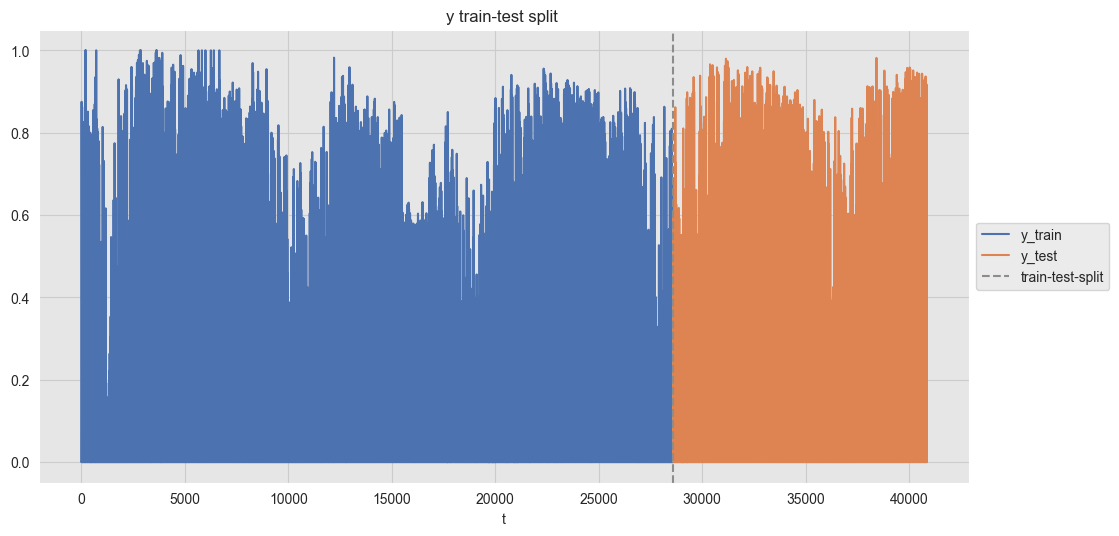

In [3]:
#Train-Test Split
n = df_bayesian.shape[0]
x = df_bayesian['time'].values.reshape(n, 1)
y = df_bayesian['kapasite_faktoru'].values.reshape(n, 1)

prop_train = 0.7
n_train = round(prop_train * n)

x_train = x[:n_train]
y_train = y[:n_train]

x_test = x[n_train:]
y_test = y[n_train:]

# Plot.
fig, ax = plt.subplots()
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color=sns_c[0], label='y_train', ax=ax)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), color=sns_c[1], label='y_test', ax=ax)
ax.axvline(x=x_train.flatten()[-1], color=sns_c[7], linestyle='--', label='train-test-split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='y train-test split ', xlabel='t', ylabel='');

In [4]:
# Define Model
with pm.Model() as model:

    # First seasonal component.
    ls_1 = pm.Gamma(name='ls_1', alpha=2.0, beta=1.0)
    period_1 = pm.Gamma(name='period_1', alpha=80, beta=2)
    gp_1 = pm.gp.Marginal(cov_func=pm.gp.cov.Periodic(input_dim=1, period=period_1, ls=ls_1))
    # Second seasonal component.
    ls_2 = pm.Gamma(name='ls_2', alpha=2.0, beta=1.0)
    period_2 = pm.Gamma(name='period_2', alpha=30, beta=2)
    gp_2 = pm.gp.Marginal(cov_func=pm.gp.cov.Periodic(input_dim=1, period=period_2, ls=ls_2))

    # Define gaussian process.
    gp = gp_1 + gp_2
    # Noise.
    sigma = pm.HalfNormal(name='sigma', sigma=10)
    # Likelihood.
    y_pred = gp.marginal_likelihood('y_pred', X=x_train, y=y_train.flatten(), noise=sigma)
    # Sample.
    trace = pm.sample(draws=2000, chains=3, tune=500)

MemoryError: Unable to allocate 6.09 GiB for an array with shape (28598, 28598, 1) and data type float64

In [ ]:
#pm.summary(trace) #summary stats

In [ ]:
#generate predictions
with model:
    
    x_train_conditional = gp.conditional('x_train_conditional', x_train)
    y_train_pred_samples = pm.sample_posterior_predictive(trace, vars=[x_train_conditional], samples=100)

    x_test_conditional = gp.conditional('x_test_conditional', x_test)
    y_test_pred_samples = pm.sample_posterior_predictive(trace, vars=[x_test_conditional], samples=100)

In [ ]:
# Train
y_train_pred_samples_mean = y_train_pred_samples['x_train_conditional'].mean(axis=0)
y_train_pred_samples_std = y_train_pred_samples['x_train_conditional'].std(axis=0)
y_train_pred_samples_mean_plus = y_train_pred_samples_mean + 2*y_train_pred_samples_std
y_train_pred_samples_mean_minus = y_train_pred_samples_mean - 2*y_train_pred_samples_std
# Test
y_test_pred_samples_mean = y_test_pred_samples['x_test_conditional'].mean(axis=0)
y_test_pred_samples_std = y_test_pred_samples['x_test_conditional'].std(axis=0)
y_test_pred_samples_mean_plus = y_test_pred_samples_mean + 2*y_test_pred_samples_std
y_test_pred_samples_mean_minus = y_test_pred_samples_mean - 2*y_test_pred_samples_std

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(x=x_train.flatten(), y=y_train.flatten(), color=sns_c[0], label='y_train', ax=ax)
sns.lineplot(x=x_test.flatten(), y=y_test.flatten(), color=sns_c[1], label='y_test', ax=ax)
ax.fill_between(
    x=x_train.flatten(), 
    y1=y_train_pred_samples_mean_minus, 
    y2=y_train_pred_samples_mean_plus, 
    color=sns_c[2], 
    alpha=0.2, 
    label='credible_interval (train)'
)
sns.lineplot(x=x_train.flatten(), y=y_train_pred_samples_mean, color=sns_c[2], label='y_pred_train', ax=ax)
ax.fill_between(
    x=x_test.flatten(), 
    y1=y_test_pred_samples_mean_minus, 
    y2=y_test_pred_samples_mean_plus, 
    color=sns_c[3], 
    alpha=0.2, 
    label='credible_interval (test)'
)
sns.lineplot(x=x_test.flatten(), y=y_test_pred_samples_mean, color=sns_c[3], label='y_pred_test', ax=ax)
ax.axvline(x=x_train.flatten()[-1], color=sns_c[7], linestyle='--', label='train-test-split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Model Predictions', xlabel='t', ylabel='');

In [ ]:
pm.save_trace(trace, 'bayesian_model.trace')